<div align="center">
    <b style="font-size: 30px; font-weight: bold; color: blue; font-family: 'Times New Roman';">Q-Site Hackathon 2024</b><br>
    <span style="font-size: 20px; font-weight: bold; color: black; font-family: 'Times New Roman';"> Classiq Open Challenge</span><br>
    <span style="font-size: 20px; font-weight: bold; color: black; font-family: 'Times New Roman';"> Team QubitSquad</span>
</div>

## **1. Introduction**

The Classiq Q-SITE Open Challenge requires the implementation of a quantum algorithm, as described in the **2020 paper** by **Tao Xin et al.**[1], for solving the linear differential equations.

$$
\left\{
\begin{aligned}
    \frac{d^2x(t)}{dt^2} + x(t) &= 0 \\
    x(0) &= 1 \\
    \frac{dx}{dt}(0) &= 1
\end{aligned} \hspace{9cm} (1)
\right.
$$

Upon solving the equation, the following tasks are required:

1. Compute the kinetic energy, $\displaystyle E_k = \frac{1}{2} \left( \frac{dx}{dt} \right)^2$, and the potential energy, $\displaystyle E_p = \frac{1}{2} x^2$, as functions of time $t$, assuming unit mass and spring constant.
   
2. Investigate the behavior of $E_k$ and $E_p$ under varying boundary conditions within the algorithm.

3. Assess the gate count while optimizing the circuit in terms of width and depth.

We begin by examining the original algorithm proposed in the paper and explore how it can be adapted to address the current challenge.

## **2. Theory**

### **2.1. The original quantum algorithm**

The paper focuses on solving the linear differential equation (LDE) 

$$\displaystyle\frac{d\mathbf{x}(t)}{dt} = \mathcal{M}\mathbf{x}(t)+\mathbf{b}, \hspace{8.8cm} (2)$$

where $\mathbf{x}(t)$ and $\mathbf{b}$ are $N$-dimensional vectors and $\mathcal{M}$ is an arbitrary $N\times N$ matrix. One can easily check that the analytical solution can be written as 

$$\displaystyle \mathbf{x}(t) = e^{\mathcal{M}t}\mathbf{x}(0) + (e^{\mathcal{M}t} - I)\mathcal{M}^{-1}\mathbf{b}, \hspace{6.3cm} (3)$$

where matrix exponentials are defined by the Taylor expansion of an exponent given by

$$\displaystyle e^{\mathcal{M}t}\equiv \sum_{k=0}^\infty \frac{(\mathcal{M}t)^k}{k!}. \hspace{9.2cm} (4)$$

While matrix inversions and matrix multiplications scale at least as $O(N^3)$ classically, a quantum algorithm is capable of achieving an $O(\log N)$ speedup in time complexity for this problem. The solution $\mathbf{x}(t)$ can first be approximated as a Taylor expansion:

$$
\begin{aligned}
    \mathbf{x}(t) \approx \sum_{m=0}^k\frac{(\mathcal{M}t)^m}{m!}\mathbf{x}(0) + \sum_{n=1}^k \frac{(\mathcal{M}t)^{n-1}t}{n!}\mathbf{b}  
\end{aligned} \hspace{5.1cm} (5)
$$

where the integer $k$ gives the approximation order ($k\rightarrow\infty$ for perfect solution). We can encode the vectors $\mathbf{x}(0)$ and $\mathbf{b}$ as normarlized quantum states:

$$
\left\{
\begin{aligned}
\displaystyle |x(0)\rangle &= \frac{1}{||x(0)||} \sum_jx_j(0) \cdot|j\rangle,\\ 
\displaystyle |b\rangle &= \frac{1}{||b||} \sum_jb_j \cdot |j\rangle, 
\end{aligned} \hspace{6.7cm} (6)
\right.
$$

and represent the matrix $\mathcal{M}$ as a quantum operator 

$$\displaystyle A = \frac{1}{||\mathcal{M}||} \sum_{i, j}\mathcal{M}_{ij} \cdot |i\rangle\langle j|. \hspace{7.7cm} (7)$$

The $k$-th order approximation thereby evaluates to

$$
\begin{aligned}
    \mathbf{x}(t)\approx \sum_{m=0}^k\frac{||x(0)||(||\mathcal{M}||At)^m}{m!}|x(0)\rangle + \sum_{n=1}^k\frac{||b||(||\mathcal{M}||A)^{n-1}t^n}{n!}|b\rangle    \hspace{1.2cm} (8)
\end{aligned}
$$

Furthermore, if **$A$ is unitary** and so are its powers, we can write $U_m\equiv A^m$, $U_n\equiv A^n$, $\displaystyle C_m \equiv \frac{1}{m!} ||x(0)||(||\mathcal{M}||t)^m$, $\displaystyle D_n \equiv \frac{1}{n!} ||b||(||\mathcal{M}||t)^{n-1}t$ and write **Equation (8)** as follows:

$$
\begin{aligned}
    |x(t)\rangle \approx\frac{1}{\mathcal{N}^2}\left(\sum_{m=0}^kC_mU_m|x(0)\rangle + \sum_{n=1}^kD_nU_{n-1}|b\rangle
          \right)
\end{aligned} \hspace{3.6cm} (9)
$$

where $\mathcal{N}^2=\mathcal{C}^2 + \mathcal{D}^2, \mathcal{C}\equiv\sqrt{\sum_mC_m}, \mathcal{D}\equiv\sqrt{\sum_nD_n}$ are normalization factors. The $j$-th element of the solution vector $\mathbf{x}(t)$ is then $x_j(t) = \mathcal{N}^2\langle j|x(t)\rangle$. The quantum circuit that extracts $x_j(t)$ is drawn below.

![LDE Quantum Circuit](imgs/classiq_open-challenge_qc.png)

The circuit is organized vertically into three components:

1. The first ancilla register, consisting of one qubit, positioned at the top,
2. The second ancilla register, composed of $T = \log_2(k+1)$ qubits, located in the middle,
3. The work register, containing $\log_2 N$ qubits for state encoding, positioned at the bottom.

Horizontally, the circuit is divided into four parts: encoding, entangling, decoding, and measurement.

#### **Encoding**

Starting off from the initial state $|\psi_0\rangle=|0\rangle\otimes|0\rangle^{\otimes T}\otimes|\phi\rangle$, one first applies a gate
$$
\begin{aligned}
    V=\frac{1}{\mathcal{N}}\begin{pmatrix}\mathcal{C} & \mathcal{D} \\ \mathcal{D} & -\mathcal{C}\end{pmatrix} \hspace{9.2cm} (10)
\end{aligned}
$$

on the top ancilla qubit to convert $\displaystyle |0\rangle\rightarrow\frac{1}{\mathcal{N}}(\mathcal{C}|0\rangle + \mathcal{D}|1\rangle)$ and generate separate subspaces for $|x(0)\rangle$ and $|b\rangle$. Then, controlled by the state of the top ancilla qubit, one applies $V_{S1}, U_{x}$ for $|0\rangle$ or $V_{S2}, U_b$ for $|1\rangle$, where $U_x|\phi\rangle = |x(0)\rangle, U_b|\phi\rangle = |b\rangle$, and the first columns of $V_{S1}, V_{S2}$ are

$$
\left\{
\begin{aligned}
    V_{S1}(:, 1) &= \frac{1}{\mathcal{C}}[\sqrt{C_0}, \sqrt{C_1}, ..., \sqrt{C_{k-1}}, \sqrt{C_k}]\\
    V_{S2}(:, 2) &= \frac{1}{\mathcal{D}}[\sqrt{D_1}, \sqrt{D_2}, ..., \sqrt{D_k}, 0]
\end{aligned}  \hspace{3.6cm} (11)
\right.
$$

and this will evolve $|\psi_0\rangle$ into

$$
\begin{aligned}
    |\psi_1\rangle = \frac{1}{\mathcal{N}}\left(
        |0\rangle\sum_{m=0}^k\sqrt{C_m}|m\rangle|x(0)\rangle + |1\rangle\sum_{n=1}^k\sqrt{D_n}|n-1\rangle|b\rangle
    \right)
\end{aligned} \hspace{1.8cm} (12)
$$

#### **Entangling**

In this part, controlled by the state of the second ancilla register, $U_m$ is applied to the work qubits if the ancilla register is in state $|m\rangle$. After all $(k+1)$ $U_m$ gates, the state is converted into

$$
\begin{aligned}
    |\psi_2\rangle = \frac{1}{\mathcal{N}}\left(
        |0\rangle\sum_{m=0}^k\sqrt{C_m}|m\rangle U_m|x(0)\rangle + |1\rangle\sum_{n=1}^k\sqrt{D_n}|n-1\rangle U_{n-1}|b\rangle
    \right)
\end{aligned} \hspace{3.2cm} (13)
$$

#### **Decoding**

In the decoding step, one simply repeat the encoding step but with $V_{S1}\rightarrow W_{S1}=V_{S1}^\dagger, V_{S2}\rightarrow W_{S2}=V_{S2}^\dagger, V\rightarrow W=V^\dagger$. This reverses the encoding operation and produces the state

$$
\begin{aligned}
    |\psi_3\rangle = \frac{1}{\mathcal{N}^2}|0\rangle\otimes|0\rangle^{\otimes T}\otimes\left(
        \sum_{m=0}^kC_mU_m|x(0)\rangle + \sum_{n=1}^kD_nU_{n-1}|b\rangle
    \right) + \text{other subspaces}
\end{aligned}  \hspace{10mm} (14)
$$

#### **Measurement**

Finally, we measure and focus only on the subspace where all ancilla qubits are in state $|0\rangle$. The 'other subspaces' part in **Equation (14)** does not matter, and the work qubits are in the solution state $|x(t)\rangle$ given by **Equation (9)**, and $x_j(t) = \mathcal{N}^2\langle j|x(t)\rangle$ can be extracted.

### **2.2. Adapting to this challenge**

To adapt this algorithm to the Classiq challenge, we need to translate the equation $\displaystyle \frac{d^2x(t)}{dt^2} + x(t) = 0$ into the paper's language. Although it might seem that we are dealing with a second-order differential equation rather than first order as shown in the paper, we can transform this second-order equation into a first-order vector equation by defining the state vector as $\displaystyle \mathbf{x}(t) = \left( x(t), \frac{dx(t)}{dt} \right)$, and this implies

$$
\begin{aligned}
    \frac{d}{dt} \begin{pmatrix}x \\ \frac{dx}{dt}\end{pmatrix} = 
    \begin{pmatrix}\frac{dx}{dt} \\ \frac{d^2x}{dt^2}\end{pmatrix}
    = \begin{pmatrix}\frac{dx}{dt} \\ -x\end{pmatrix}, \hspace{10.3cm} (15)
\end{aligned}
$$

which can be written as

$$
\frac{d}{dt} \begin{pmatrix}x \\ \frac{dx}{dt} \end{pmatrix} =
\begin{pmatrix}
    0 & 1 \\ -1 & 0
\end{pmatrix}
\begin{pmatrix}x \\ \frac{dx}{dt}
\end{pmatrix}, \hspace{9.8cm} (16)   
$$

which is of the form used in the paper, with $\mathcal{M} = \begin{pmatrix} 0 & 1 \\ -1 & 0\end{pmatrix}$ and $\mathbf{b}=0$. The initial conditions $x(0) = 1$, $\displaystyle \frac{dx(0)}{dt} = 1$ are then translated into $\mathbf{x}(0) = (1, 1)$.

As $\mathcal{M}$ is already unitary, we can use the algorithm above and define $A=\mathcal{M}$. Therefore,

$$
\left\{
\begin{aligned}
    \mathcal{D} &= 0, \\
    D_n &=0, \\
    U_m &= A^m=\mathcal{M}^m, \\
    C_m &= ||x(0)||(||\mathcal{M}||t)^m/m! = \sqrt{2}t^m/m!, \\
    \mathcal{N} &= \mathcal{C} = \sqrt{\sum_{m=0}^k C_m}, \\
    V &= \begin{pmatrix}1 & 0\\0 & -1\end{pmatrix}, \\
    |x(0)\rangle &= \frac{1}{\sqrt{2}} (1, 1), \\
    V_{S1}(:, 1) &= \frac{1}{\mathcal{C}}(1, \sqrt{t}, \sqrt{\frac{t^2}{2!}}, \sqrt{\frac{t^3}{3!}}, ..., \sqrt{\frac{t^k}{k!}}),
\end{aligned} \hspace{7cm} (17) 
\right.   
$$

Note that since $\mathbf{b}=0$, the top ancilla qubit for separating the $x(0)$ and $b$ subspace is no longer necessary and so is the $V$ gate. We only need $\log_2 (k+1)$ ancilla qubits and $\log_2 2=1$ work qubit for the challenge.

## **3. Implementation**

### **3.1. Code structure**

In [2]:
from classiq import *
import numpy as np
from scipy.special import factorial as fact
from classiq.execution import ExecutionPreferences
import matplotlib.pyplot as plt

In Classiq SDK, instead of explicitly applying gates in the encoding stage, we can directly prepare the state of the $\log_2 (k+1)$ ancilla register according to $V_{S1}$ in **Equation (17)**.

In [2]:
@qfunc
def prep_ancilla(ancilla_reg: QNum, bound: CReal):
    '''
    Prepares the ancilla register in the state specified by V_S1.
    '''
    C_m = np.array([np.sqrt(2) * t**m / fact(m) for m in range(k + 1)])
    C_m = C_m / np.sum(C_m)
    # Prep ancilla register according to Vs1
    inplace_prepare_state(probabilities=list(C_m), bound=bound, target=ancilla_reg)

Then we write the function for preparing the work qubit and creating entanglement between the work qubit and the ancilla register.

In [3]:
@qfunc
def operate(ancilla_reg: QNum, work_q: QBit, k: CInt):
    '''
    Prepare the work qubit and entangle each state |m> of ancilla register with U_m operating on work qubit.
    U_(0 mod 4) = I; U_(1 mod 4) = ZX; U_(2 mod 4) = -I = RZ(2π); U(3 mod 4) = XZ.
    '''
    H(work_q)       # prepares the work qubit in |x(0)> = |+>
    @qfunc
    def compose(gate1: QCallable[QBit], gate2: QCallable[QBit], q: QBit):
        '''
        Acts gate1 then gate2 on qubit q. 
        '''
        gate1(q)
        gate2(q)

    repeat(
        count=k+1,
        iteration=lambda index: control(ctrl=(ancilla_reg==index), 
                                        stmt_block=lambda: if_(condition=((index%4)==0), then=lambda: I(work_q),
                                                       else_=lambda: if_(condition=((index%4)==1), then=lambda: compose(X, Z, work_q),
                                                                 else_=lambda: if_(condition=((index%4)==2), then=lambda: RZ(2*np.pi, work_q),
                                                                           else_=lambda: compose(Z, X, work_q)))))
    )

Since the decoding part of the quantum circuit is just the inverse of the encoding part implemented by ``prep_ancilla()``, we can use a ``within_apply`` statement to do the whole operation.

In [4]:
@qfunc
def main(work_q: Output[QBit], ancilla_reg: Output[QNum]):
    '''
    Decodes the x(t) solution vector from its entanglement with |00...0> of ancilla register state.
    '''
    allocate(1, work_q)
    allocate(np.ceil(np.log2(k + 1)), ancilla_reg)
    within_apply(
        within=lambda: prep_ancilla(ancilla_reg, bound),
        apply=lambda: operate(ancilla_reg, work_q, k)
    )
    if_(condition=(apply_final_H!=0), then=lambda: H(work_q), else_=lambda: I(work_q))

However, there is still a problem with this algorithm; it cannot distinguish between positive and negative $\displaystyle \frac{dx}{dt}$ values. This is because the probabilities we measure are not sensitive to the sign of amplitudes. To solve this, an extra option is added to the above ``main()`` function to apply a Hadamard gate to the work qubit before measurement to measure in x-basis. In this way, the difference in the $|0 \rangle$ and $|1\rangle$ counts from a second round of measurement would give the relative signs between $x(0)$ and $\displaystyle \frac{dx(0)}{dt}$, although there is still an overall sign ambiguity due to the inability to detect global phase. This would be one drawback of this algorithm, and for now we have to rely on the knowledge that $x(t) > 0$ for $0 < t < 1$.

Finally, with some helper functions and some extra codes to extract the solution vector from counts, we can test the code at $t=1$.

In [5]:
def eval_N2(t, k):
    C_m = np.array([np.sqrt(2) * t**m / fact(m) for m in range(k + 1)])
    return np.sum(C_m)

def results2counts(results):
    '''
    Converts the results str to |0> and |1> counts.
    '''
    results = '''{}'''.format(results)
    results = results.replace("\':", "\',").replace("{", "\"{").replace("}", "}\"").replace("[", "{").replace("]", "}")
    wq_count0_keyword = "{'work_q', 0.0, 'ancilla_reg', 0.0}"    # the x(t) counts
    wq_count1_keyword = "{'work_q', 1.0, 'ancilla_reg', 0.0}"    # the dx/dt(t) counts
    wq_count0, wq_count1 = 0, 0

    for res in eval(results):
        if wq_count0_keyword in res:
            wq_count0 = eval(results)[wq_count0_keyword]
        elif wq_count1_keyword in res:
            wq_count1 = eval(results)[wq_count1_keyword]
    
    return wq_count0, wq_count1

In [6]:
def simulate(t_val, k, total_counts, need_sign_correction=True):
    global t
    t = t_val
    N2_factor = eval_N2(t, k)
    global apply_final_H
    apply_final_H = 0
    qmod = create_model(main)
    qmod = set_execution_preferences(
        qmod,
        ExecutionPreferences(
            num_shots=total_counts
        ),
    )
    quantum_program = synthesize(qmod)
    print("QMOD synthesized.")
    # show(quantum_program)
    job = execute(quantum_program)
    results = job.result()[0].value.parsed_counts
    wq_count0, wq_count1 = results2counts(results)
    sign_correction_factor = 1
    if need_sign_correction:
        apply_final_H = 1
        qmod_h = create_model(main)
        qmod_h = set_execution_preferences(
            qmod_h,
            ExecutionPreferences(
                num_shots=total_counts
            ),
        )
        quantum_program_h = synthesize(qmod_h)
        print("QMOD_H synthesized.")
        # show(quantum_program)
        job_h = execute(quantum_program_h)
        results_h = job_h.result()[0].value.parsed_counts
        wq_count0_h, wq_count1_h = results2counts(results_h)
        sign_correction_factor = (-1)**( wq_count0_h < wq_count1_h)

    x_t = N2_factor * np.sqrt(wq_count0 / total_counts)
    dxdt = N2_factor * np.sqrt(wq_count1 / total_counts) * sign_correction_factor

    print('x(t)={:.3f} and dx/dt(t)={:.3f} at t={}.'.format(x_t, dxdt, t))
    
    write_qmod(qmod, 'k{}_bound{:.3f}_t{:.1f}_noConstraints'.format(k, bound, t_val))
    qasm = QuantumProgram.from_qprog(quantum_program).qasm
    file_path = "k{}_bound{:.3f}_t{:.1f}_noConstraints.qasm".format(k, bound, t_val)
    with open(file_path, 'w') as file:
        file.write(qasm)
    
    return [x_t, dxdt]

In [7]:
k = 31
bound = 0.001
t = 1
apply_final_H = CInt('apply_final_H')
apply_final_H = 0
simulate(t, k, total_counts=1e6)

QMOD synthesized.
QMOD_H synthesized.
x(t)=1.385 and dx/dt(t)=-0.299 at t=1.


[1.384633102942848, -0.2990851269014466]

The analytical solution for this problem is $x^*(t)=\sin(t)+\cos(t)$ and $\displaystyle\frac{dx^*}{dt}(t)=\cos(t)-\sin(t)$, and they evaluate to $x^*(1)\sim1.382$ and $\displaystyle\frac{dx^*}{dt}(1)\sim-0.301$ at $t=1$. The algorithm's approximations are therefore within ~1% of the exact values, and the algorithm gives the expected signs. Now let's try plotting the solution as a function of time.

In [8]:
t_vals = np.arange(start=0, stop=1.6, step=0.1)
x_t_theory = np.sin(t_vals) + np.cos(t_vals)
dx_dt_theory = np.cos(t_vals) - np.sin(t_vals)
x_t_simulation = []
dx_dt_simulation = []
for t_val in t_vals:
    [x_t, dx_dt] = simulate(t_val=t_val, k=31, total_counts=1e6)
    x_t_simulation.append(x_t)
    dx_dt_simulation.append(dx_dt)

QMOD synthesized.
QMOD_H synthesized.
x(t)=1.001 and dx/dt(t)=0.999 at t=0.0.
QMOD synthesized.
QMOD_H synthesized.
x(t)=1.095 and dx/dt(t)=0.894 at t=0.1.
QMOD synthesized.
QMOD_H synthesized.
x(t)=1.179 and dx/dt(t)=0.780 at t=0.2.
QMOD synthesized.
QMOD_H synthesized.
x(t)=1.250 and dx/dt(t)=0.660 at t=0.30000000000000004.
QMOD synthesized.
QMOD_H synthesized.
x(t)=1.309 and dx/dt(t)=0.532 at t=0.4.
QMOD synthesized.
QMOD_H synthesized.
x(t)=1.356 and dx/dt(t)=0.398 at t=0.5.
QMOD synthesized.
QMOD_H synthesized.
x(t)=1.390 and dx/dt(t)=0.262 at t=0.6000000000000001.
QMOD synthesized.
QMOD_H synthesized.
x(t)=1.408 and dx/dt(t)=0.122 at t=0.7000000000000001.
QMOD synthesized.
QMOD_H synthesized.
x(t)=1.415 and dx/dt(t)=-0.023 at t=0.8.
QMOD synthesized.
QMOD_H synthesized.
x(t)=1.405 and dx/dt(t)=-0.162 at t=0.9.
QMOD synthesized.
QMOD_H synthesized.
x(t)=1.381 and dx/dt(t)=-0.302 at t=1.0.
QMOD synthesized.
QMOD_H synthesized.
x(t)=1.343 and dx/dt(t)=-0.436 at t=1.1.
QMOD synthesiz

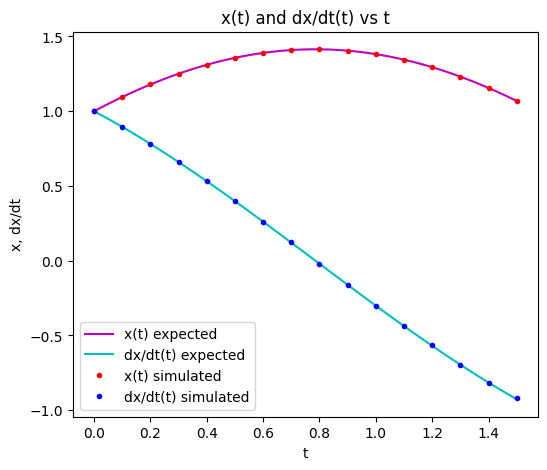

In [9]:
t_continuous = np.linspace(start=0, stop=1.5, num=100)
x_t_theory = np.sin(t_continuous) + np.cos(t_continuous)
dx_dt_theory = np.cos(t_continuous) - np.sin(t_continuous)

fig, ax = plt.subplots(figsize=(6, 5))
plt.xlabel('t')
plt.ylabel('x, dx/dt')
plt.title("x(t) and dx/dt(t) vs t")
plt.plot(t_continuous, x_t_theory, 'm-', label="x(t) expected")
plt.plot(t_continuous, dx_dt_theory, 'c-', label="dx/dt(t) expected")
plt.plot(t_vals, x_t_simulation, 'r.', label="x(t) simulated")
plt.plot(t_vals, dx_dt_simulation, 'b.', label="dx/dt(t) simulated")
plt.legend()
plt.savefig('position-velocity-vs-time.png', dpi=300, bbox_inches='tight')
plt.show()

So with $k=31$ and bound=0.001 the solution returned by the algorithm agrees very well with prediction. Let's now see how less strict bounds are going to affect the accuracy of the algorithm by looking at the time-dependence of kinetic and potential energy.

### **3.2. Bound optimization**

In [10]:
bound_vals = [0.001, 0.01, 0.05, 0.1]
t_cont = np.linspace(start=0, stop=1, num=100)
t_vals_2 = np.arange(start=0, stop=1.1, step=0.1)
x_t_pred = np.sin(t_cont) + np.cos(t_cont)
dx_dt_pred = np.cos(t_cont) - np.sin(t_cont)
x_t_exp = []
dx_dt_exp = []
for bound_val in bound_vals:
    print("Studying bound={:.3f}...".format(bound_val))
    bound = bound_val
    x_t_exp_bound = []
    dx_dt_exp_bound = []
    for t_val in t_vals_2:
        [x_t, dx_dt] = simulate(t_val=t_val, k=31, total_counts=1e6, need_sign_correction=False)    
        # sign correction is unnecessary since energies are not sign-sensitive
        x_t_exp_bound.append(x_t)
        dx_dt_exp_bound.append(dx_dt)
    x_t_exp.append(x_t_exp_bound)
    dx_dt_exp.append(dx_dt_exp_bound)

Studying bound=0.001...
QMOD synthesized.
x(t)=1.000 and dx/dt(t)=1.000 at t=0.0.
QMOD synthesized.
x(t)=1.096 and dx/dt(t)=0.894 at t=0.1.
QMOD synthesized.
x(t)=1.178 and dx/dt(t)=0.783 at t=0.2.
QMOD synthesized.
x(t)=1.251 and dx/dt(t)=0.660 at t=0.30000000000000004.
QMOD synthesized.
x(t)=1.310 and dx/dt(t)=0.532 at t=0.4.
QMOD synthesized.
x(t)=1.357 and dx/dt(t)=0.401 at t=0.5.
QMOD synthesized.
x(t)=1.390 and dx/dt(t)=0.262 at t=0.6000000000000001.
QMOD synthesized.
x(t)=1.409 and dx/dt(t)=0.123 at t=0.7000000000000001.
QMOD synthesized.
x(t)=1.414 and dx/dt(t)=0.022 at t=0.8.
QMOD synthesized.
x(t)=1.403 and dx/dt(t)=0.163 at t=0.9.
QMOD synthesized.
x(t)=1.381 and dx/dt(t)=0.302 at t=1.0.
Studying bound=0.010...
QMOD synthesized.
x(t)=1.000 and dx/dt(t)=1.000 at t=0.0.
QMOD synthesized.
x(t)=1.095 and dx/dt(t)=0.895 at t=0.1.
QMOD synthesized.
x(t)=1.180 and dx/dt(t)=0.778 at t=0.2.
QMOD synthesized.
x(t)=1.250 and dx/dt(t)=0.654 at t=0.30000000000000004.
QMOD synthesized.
x(

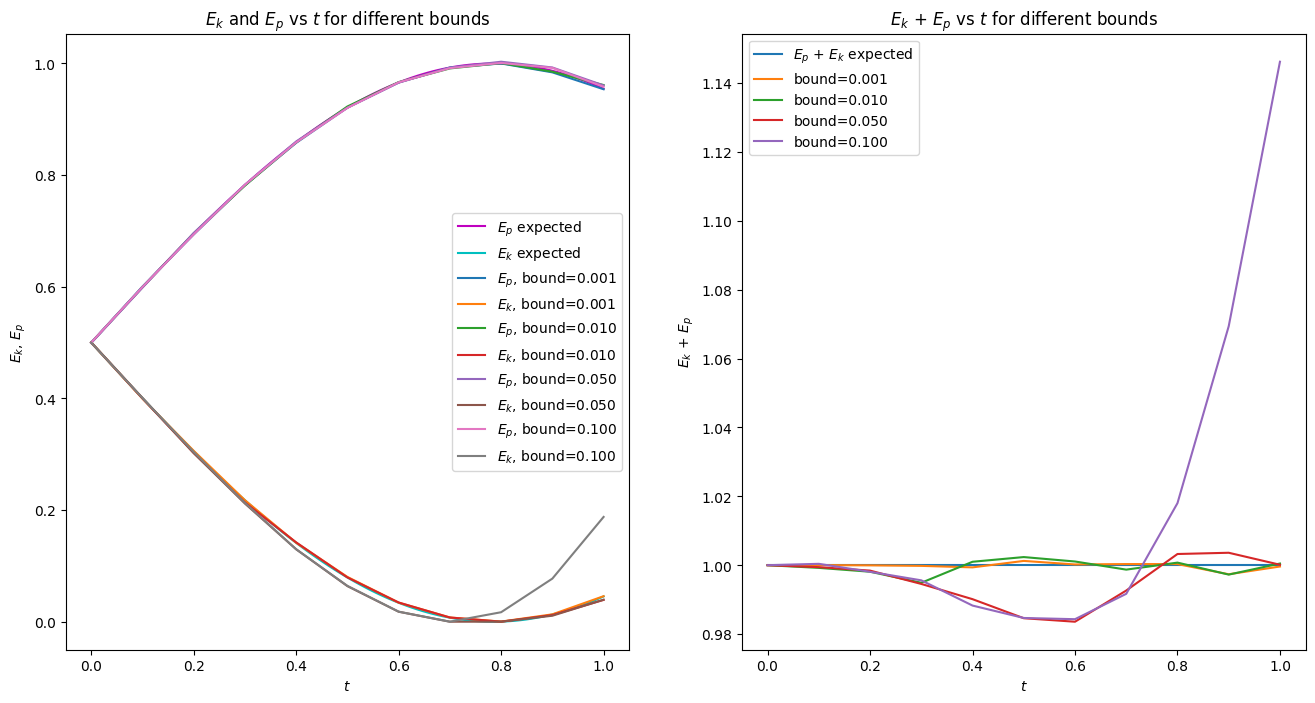

In [11]:
x_t_exp = np.array(x_t_exp)
dx_dt_exp = np.array(dx_dt_exp)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$E_k$, $E_p$')
ax1.set_title(r'$E_k$ and $E_p$ vs $t$ for different bounds')
ax1.plot(t_cont, 0.5 * (x_t_pred)**2, 'm-', label=r'$E_p$ expected')
ax1.plot(t_cont, 0.5 * (dx_dt_pred)**2, 'c-', label=r'$E_k$ expected')
ax2.set_title(r'$E_k$ + $E_p$ vs $t$ for different bounds')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$E_k$ + $E_p$')
ax2.plot(t_cont, 0.5 * (x_t_pred)**2 + 0.5 * (dx_dt_pred)**2, label=r'$E_p$ + $E_k$ expected')
for i in range(4):
    ax1.plot(t_vals_2, 0.5 * x_t_exp[i]**2, label=r'$E_p$, bound={:.3f}'.format(bound_vals[i]))
    ax1.plot(t_vals_2, 0.5 * dx_dt_exp[i]**2, label=r'$E_k$, bound={:.3f}'.format(bound_vals[i]))
    ax2.plot(t_vals_2, 0.5 * x_t_exp[i]**2+0.5 * dx_dt_exp[i]**2, label="bound={:.3f}".format(bound_vals[i]))
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.savefig('ek-ep-vs-t-bounds.png', dpi=300, bbox_inches='tight')
plt.show()

We see that as we use larger and larger bounds of state preparation, both $E_k$ and $E_p$ deviate more and more from the expectation, and total energy $E_k+E_p$ is no longer well conserved especially at large t. We will stick to bound=0.001 for now.

Let's finally look at how the circuit can be further optimized in term of circuit depth and width. We first look at the circuit parameters of one of the unconstrained data with k=31 and bound=0.001.

In [12]:
k = 31
bound = 0.001
qmod = create_model(main)
quantum_program = synthesize(qmod)
circuit_width = QuantumProgram.from_qprog(quantum_program).data.width
circuit_depth = QuantumProgram.from_qprog(quantum_program).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}.")

The circuit width is 9 and the circuit_depth is 4553.


We can see the circuit is narrow but quite deep. Let's try to optimize its depth.

In [13]:
qmod_depth = set_constraints(
    qmod, Constraints(optimization_parameter="depth", max_width=15)
)
qprog_depth = synthesize(qmod_depth)
circuit_width = QuantumProgram.from_qprog(qprog_depth).data.width
circuit_depth = QuantumProgram.from_qprog(qprog_depth).transpiled_circuit.depth
print(f"The constrained circuit width is {circuit_width} and the circuit_depth is {circuit_depth}.")

The constrained circuit width is 15 and the circuit_depth is 2426.


Or alternatively, optimize its width even further.

In [14]:
qmod_depth = set_constraints(
    qmod, Constraints(optimization_parameter="width", max_depth=8000)
)
qprog_depth = synthesize(qmod_depth)
circuit_width = QuantumProgram.from_qprog(qprog_depth).data.width
circuit_depth = QuantumProgram.from_qprog(qprog_depth).transpiled_circuit.depth
print(f"The constrained circuit width is {circuit_width} and the circuit_depth is {circuit_depth}.")

The constrained circuit width is 7 and the circuit_depth is 7515.


So the minimum circuit width possible is when we have exactly one extra auxiliary qubit beside the singular work qubit and the 5-qubit ancilla register. The circuit width and depth turn out to be fairly flexible to optimization. Let's also see how for the unconstrained condition, the circuit depth and width depend on the bound value for state preparation.

In [15]:
bound_vals = np.arange(start=0.001, stop=0.052, step=0.005)
circuit_widths = []
circuit_depths = []
for bound_val in bound_vals:
    bound = bound_val
    qmod = create_model(main)
    qprog = synthesize(qmod)
    circuit_width = QuantumProgram.from_qprog(qprog).data.width
    circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
    circuit_widths.append(circuit_width)
    circuit_depths.append(circuit_depth)
    print('Done for bound {:.3f}.'.format(bound_val))

Done for bound 0.001.
Done for bound 0.006.
Done for bound 0.011.
Done for bound 0.016.
Done for bound 0.021.
Done for bound 0.026.
Done for bound 0.031.
Done for bound 0.036.
Done for bound 0.041.
Done for bound 0.046.
Done for bound 0.051.


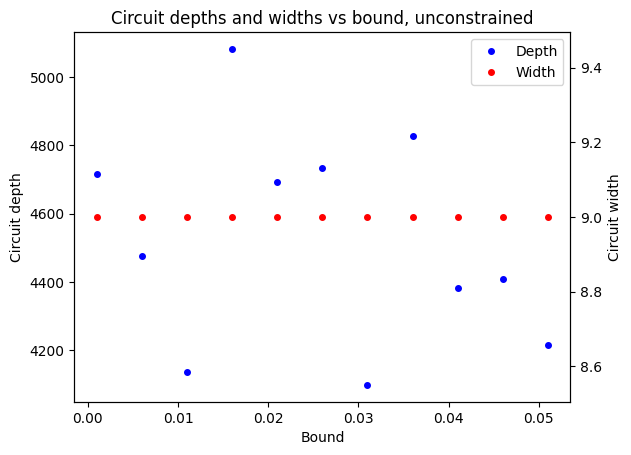

In [16]:
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()

ax0.set_xlabel("Bound")
ax0.set_ylabel("Circuit depth")
ax1.set_ylabel("Circuit width")
p0 = ax0.plot(bound_vals, circuit_depths, 'b.', markersize=8, label="Depth")
p1 = ax1.plot(bound_vals, circuit_widths, 'r.', markersize=8, label="Width")
plt.title("Circuit depths and widths vs bound, unconstrained")
plt.legend(handles=p0+p1, loc="best")
plt.savefig('dephts-widths-vs-bound.png', dpi=300, bbox_inches='tight')
plt.show()

Here we can see that up to the point bound=0.05 beyond which the algorithm becomes unreliable, circuit width doesn't depend on bound while circuit depth has a maximum reduction of ~20% as bound is increased, yet the dependence is not strictly monotonic. Therefore, for both accuracy and efficiency, bound=0.001 is a good value for circuit optimization.

### **3.3. k optimization**

And finally, let's look at how variation in k-value is going to affect the $E_k(t), E_p(t)$ curves and pick out an optimal k value for circuit optimization.

In [17]:
bound = 0.001
t_vals_2 = np.arange(start=0, stop=1.1, step=0.1)
k_vals = [31, 15, 7, 3]
x_t_exp = []
dx_dt_exp = []
for k_val in k_vals:
    print("Studying k={}...".format(k_val))
    k = k_val
    x_t_exp_k = []
    dx_dt_exp_k = []
    for t_val in t_vals_2:
        [x_t, dx_dt] = simulate(t_val=t_val, k=k_val, total_counts=1e6, need_sign_correction=False)    
        # sign correction is unnecessary since energies are not sign-sensitive
        x_t_exp_k.append(x_t)
        dx_dt_exp_k.append(dx_dt)
    x_t_exp.append(x_t_exp_k)
    dx_dt_exp.append(dx_dt_exp_k)

Studying k=31...
QMOD synthesized.
x(t)=1.000 and dx/dt(t)=1.000 at t=0.0.
QMOD synthesized.
x(t)=1.095 and dx/dt(t)=0.894 at t=0.1.
QMOD synthesized.
x(t)=1.178 and dx/dt(t)=0.782 at t=0.2.
QMOD synthesized.
x(t)=1.251 and dx/dt(t)=0.660 at t=0.30000000000000004.
QMOD synthesized.
x(t)=1.310 and dx/dt(t)=0.532 at t=0.4.
QMOD synthesized.
x(t)=1.356 and dx/dt(t)=0.400 at t=0.5.
QMOD synthesized.
x(t)=1.389 and dx/dt(t)=0.260 at t=0.6000000000000001.
QMOD synthesized.
x(t)=1.409 and dx/dt(t)=0.125 at t=0.7000000000000001.
QMOD synthesized.
x(t)=1.414 and dx/dt(t)=0.022 at t=0.8.
QMOD synthesized.
x(t)=1.406 and dx/dt(t)=0.162 at t=0.9.
QMOD synthesized.
x(t)=1.382 and dx/dt(t)=0.303 at t=1.0.
Studying k=15...
QMOD synthesized.
x(t)=1.000 and dx/dt(t)=1.000 at t=0.0.
QMOD synthesized.
x(t)=1.094 and dx/dt(t)=0.895 at t=0.1.
QMOD synthesized.
x(t)=1.179 and dx/dt(t)=0.782 at t=0.2.
QMOD synthesized.
x(t)=1.251 and dx/dt(t)=0.660 at t=0.30000000000000004.
QMOD synthesized.
x(t)=1.310 and d

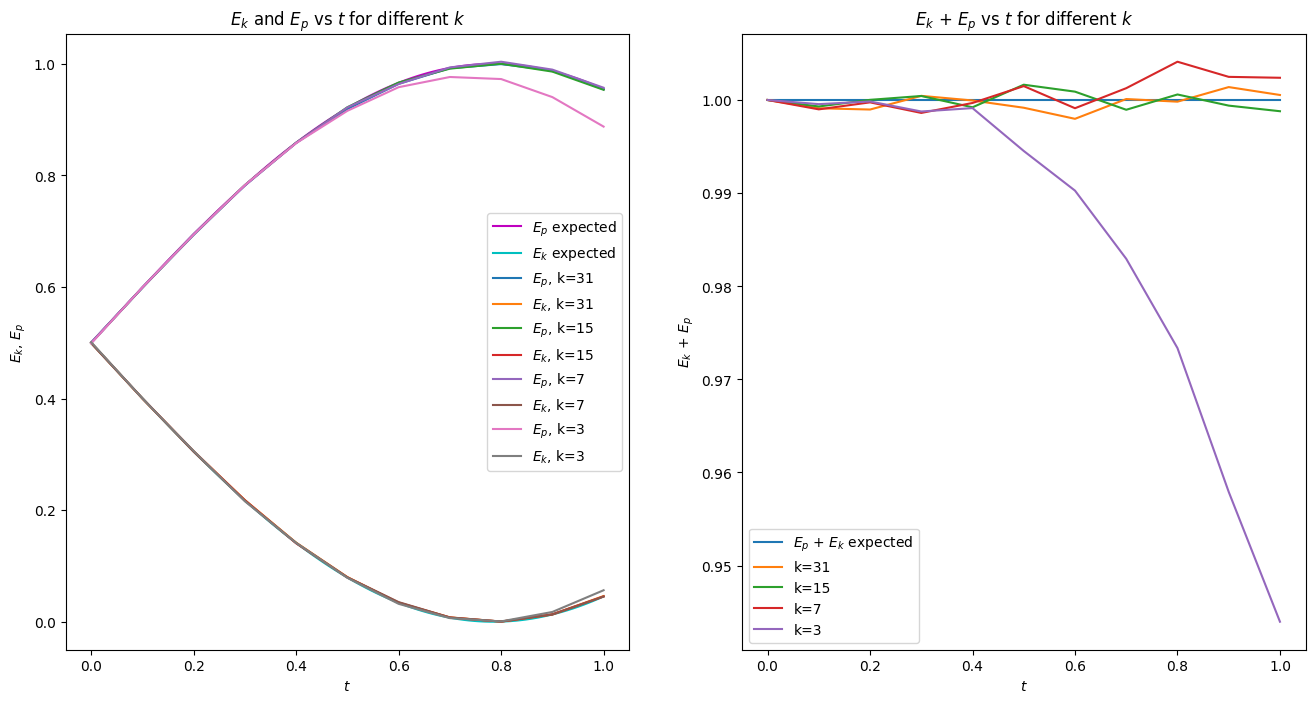

In [18]:
t_cont = np.linspace(start=0, stop=1, num=100)
x_t_pred = np.sin(t_cont) + np.cos(t_cont)
dx_dt_pred = np.cos(t_cont) - np.sin(t_cont)
x_t_exp = np.array(x_t_exp)
dx_dt_exp = np.array(dx_dt_exp)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$E_k$, $E_p$')
ax1.set_title(r'$E_k$ and $E_p$ vs $t$ for different $k$')
ax1.plot(t_cont, 0.5 * (x_t_pred)**2, 'm-', label=r'$E_p$ expected')
ax1.plot(t_cont, 0.5 * (dx_dt_pred)**2, 'c-', label=r'$E_k$ expected')
ax2.set_title(r'$E_k$ + $E_p$ vs $t$ for different $k$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$E_k$ + $E_p$')
ax2.plot(t_cont, 0.5 * (x_t_pred)**2 + 0.5 * (dx_dt_pred)**2, label=r'$E_p$ + $E_k$ expected')
for i in range(4):
    ax1.plot(t_vals_2, 0.5 * x_t_exp[i]**2, label=r'$E_p$, k={}'.format(k_vals[i]))
    ax1.plot(t_vals_2, 0.5 * dx_dt_exp[i]**2, label=r'$E_k$, k={}'.format(k_vals[i]))
    ax2.plot(t_vals_2, 0.5 * x_t_exp[i]**2+0.5 * dx_dt_exp[i]**2, label="k={}".format(k_vals[i]))
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.savefig('ek-ep-vs-t-k.png', dpi=300, bbox_inches='tight')
plt.show()

So it seems that $k=31$ might be a slight overkill for this problem as all circuits with $k\geq7$ perform pretty well in this interval. Let's look at how circuit depths and widths (unconstrained) depend on $k$.

In [19]:
k_vals = [127, 63, 31, 15, 7, 3]
circuit_widths = []
circuit_depths = []
for k_val in k_vals:
    k = k_val
    qmod = create_model(main)
    qprog = synthesize(qmod)
    circuit_width = QuantumProgram.from_qprog(qprog).data.width
    circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
    circuit_widths.append(circuit_width)
    circuit_depths.append(circuit_depth)
    print('Done for k={}.'.format(k_val))

Done for k=127.
Done for k=63.
Done for k=31.
Done for k=15.
Done for k=7.
Done for k=3.


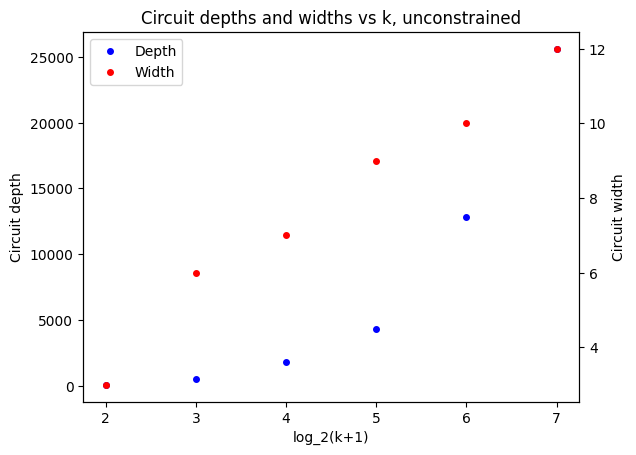

In [20]:
k_vals = np.array(k_vals)
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()
ax0.set_xlabel("log_2(k+1)")
ax0.set_ylabel("Circuit depth")
ax1.set_ylabel("Circuit width")
p0 = ax0.plot(np.log2(k_vals+1), circuit_depths, 'b.', markersize=8, label="Depth")
p1 = ax1.plot(np.log2(k_vals+1), circuit_widths, 'r.', markersize=8, label="Width")
plt.title("Circuit depths and widths vs k, unconstrained")
plt.legend(handles=p0+p1, loc="best")
plt.savefig('dephts-widths-vs-k.png', dpi=300, bbox_inches='tight')
plt.show()

We can see that while circuit width scales approximately linearly with $\log_2(k+1)$ (number of ancilla qubits) as expected, circuit depth increases dramatically with k while not providing a very significant boost in accuracy. Therefore, a k value of ~15 might be a good choice for this problem that provides both good accuracy and efficient circuit. The analysis routine used in this document can also be adapted to other problems by modifying the $\mathcal{M}$ matrix used in the ``operate()`` function.

## **4. Summary**

In this work, we investigated a quantum algorithm[1] for solving linear differential equations. The algorithm is adapted to solve the second-order harmonic oscillator equation, and the routine can be conveniently implemented in Classiq with high-level state preparation and operation programs. By building a quantum circuit for each time point, one can obtain a solution vector $\displaystyle \left(x(t), \frac{dx}{dt}(0)\right)$ from a set of initial conditions $\displaystyle \left(x(0), \frac{dx}{dt}(0)\right)$. Results turn out to agree with theory within ~1%, and the optimal bound and k values found to give both good accuracy and efficient circuits (in terms of circuit depth and width) are bound=0.001 and $k=15$. Further work can be done on variants of the harmonic oscillator equations (e.g., with damping) or other more complex differential equations that are expected to cost more resources to test the applicability of this quantum algorithm. One crucial drawback of this algorithm is an overall sign ambiguity due to the inability to detect any global phase, and this can be tackled by limiting discussion to a finite domain where the solution's overall sign is relatively well-known.

## **5. References**

[1] Tao Xin, Shijie Wei, Jianlian Cui, Junxiang Xiao, Iñigo Arrazola, Lucas Lamata, Xiangyu Kong, Dawei Lu, Enrique Solano, and Guilu Long. (2020). Quantum algorithm for solving linear differential equations: Theory and experiment. *Phys. Rev. A*, 101(3), 032307. [https://doi.org/10.1103/PhysRevA.101.032307](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.032307)